In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir 
import muon as mu

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [3]:
adata = sc.read_10x_h5("/Users/jerryaaaaaa/scTCR-seq/sample_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata_tcr = ir.io.read_10x_vdj("/Users/jerryaaaaaa/scTCR-seq/filtered_contig_annotations.csv")

reading /Users/jerryaaaaaa/scTCR-seq/sample_filtered_feature_bc_matrix.h5
 (0:00:02)


/opt/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [4]:
adata.var_names_make_unique()

In [5]:
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [6]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


In [7]:
mu.pp.filter_obs(mdata, "airr:receptor_type", lambda x: x == "TCR")
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x == "single pair")

Gene Expression Processing

In [8]:
sc.pp.filter_cells(mdata["gex"], min_genes=200)
sc.pp.filter_genes(mdata["gex"], min_cells=3)

filtered out 16665 genes that are detected in less than 3 cells


In [11]:
mdata["gex"].var["mt"] = mdata["gex"].var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    mdata["gex"], qc_vars=["mt"], percent_top=None, log1p=None, inplace=True
)

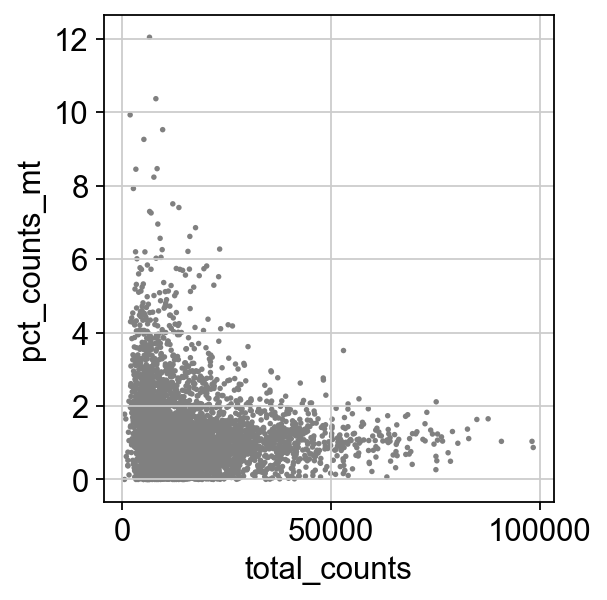

In [12]:
sc.pl.scatter(mdata["gex"], x="total_counts", y="pct_counts_mt")

In [13]:
sc.pp.normalize_total(mdata["gex"], target_sum=1e4)
sc.pp.log1p(mdata["gex"])
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=3000)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
mdata["gex"].raw = mdata["gex"].copy()

In [15]:
sc.pp.scale(mdata["gex"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [16]:
mdata["gex"].layers["scaled"] = sc.pp.scale(mdata["gex"], copy=True).X

In [17]:
mdata.update()

In [18]:
sc.tl.pca(mdata["gex"])
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
sc.tl.leiden(mdata["gex"], resolution=0.2)

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering


/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_5024/3821785558.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata["gex"], resolution=0.2)


    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


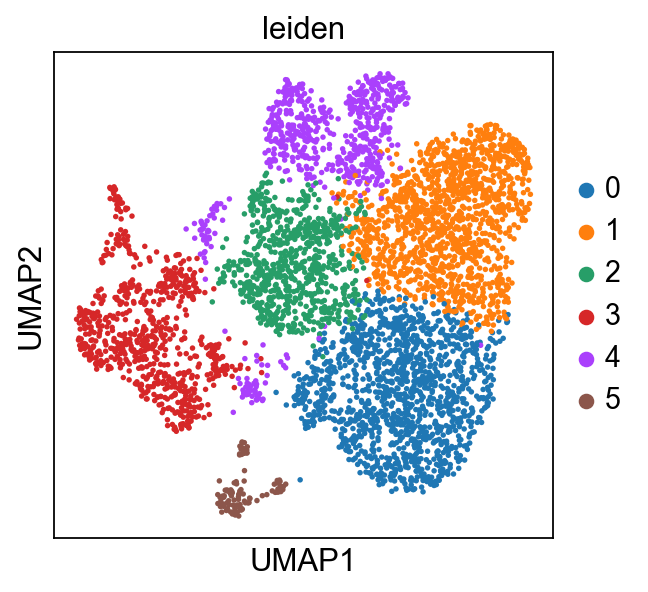

In [19]:
sc.pl.umap(mdata["gex"], color="leiden")

TCR processing

In [21]:
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.


In [22]:
ir.tl.clonotype_network(mdata, min_cells=2)

In [23]:
#Identify frequent T-cell clone
clone_counts = mdata["airr"].obs["clone_id"].value_counts()
frequent_clones = clone_counts[clone_counts >= 5].index.tolist()

In [25]:
#Subset data
mdata_filtered = mdata[mdata["airr"].obs["clone_id"].isin(frequent_clones)].copy()

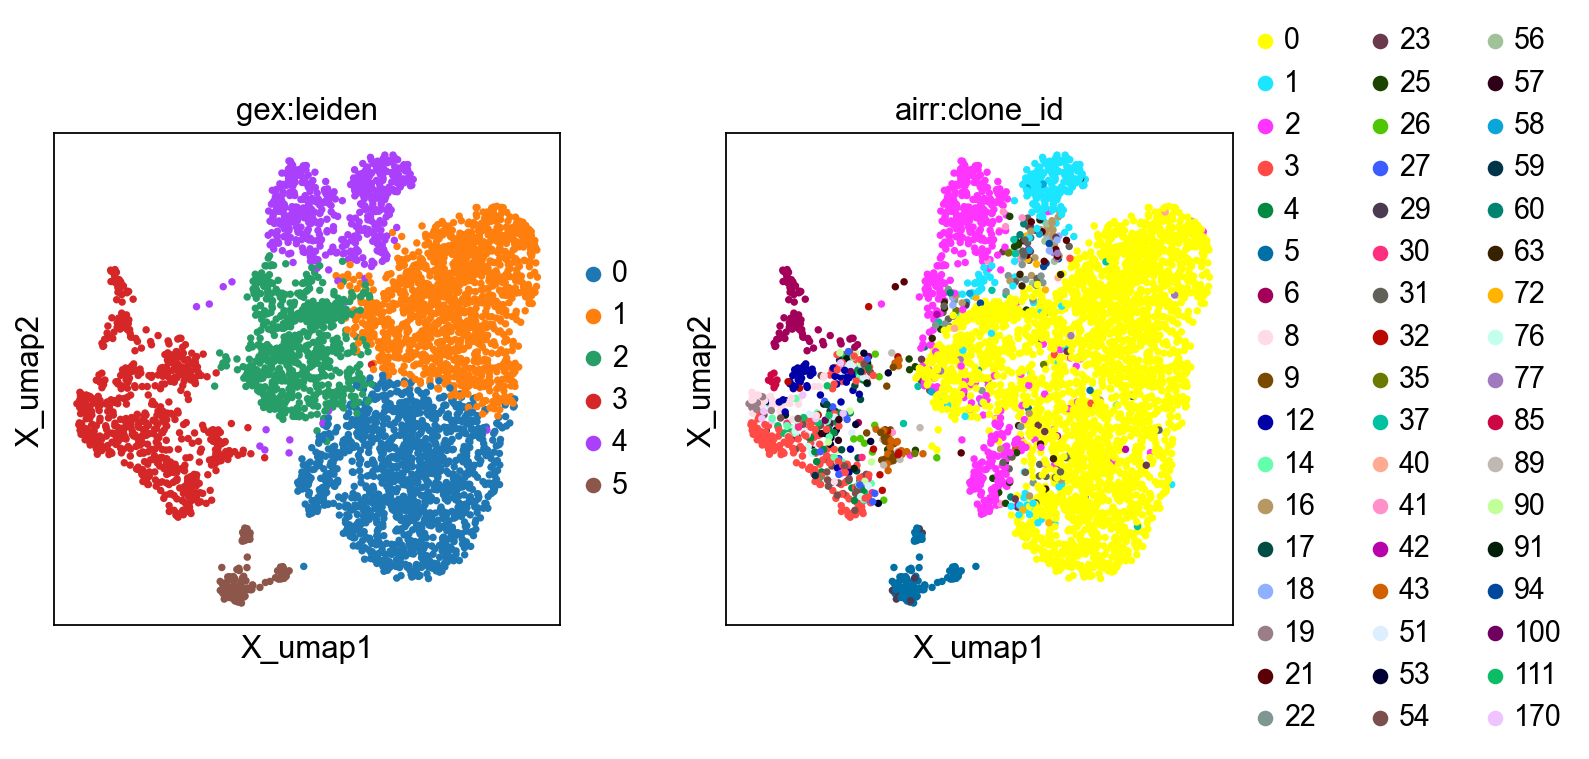

In [43]:
mu.pl.embedding(
    mdata_filtered,
    basis="gex:umap",
    color=["gex:leiden", "airr:clone_id"],
    size=45,
)

Cluster Define

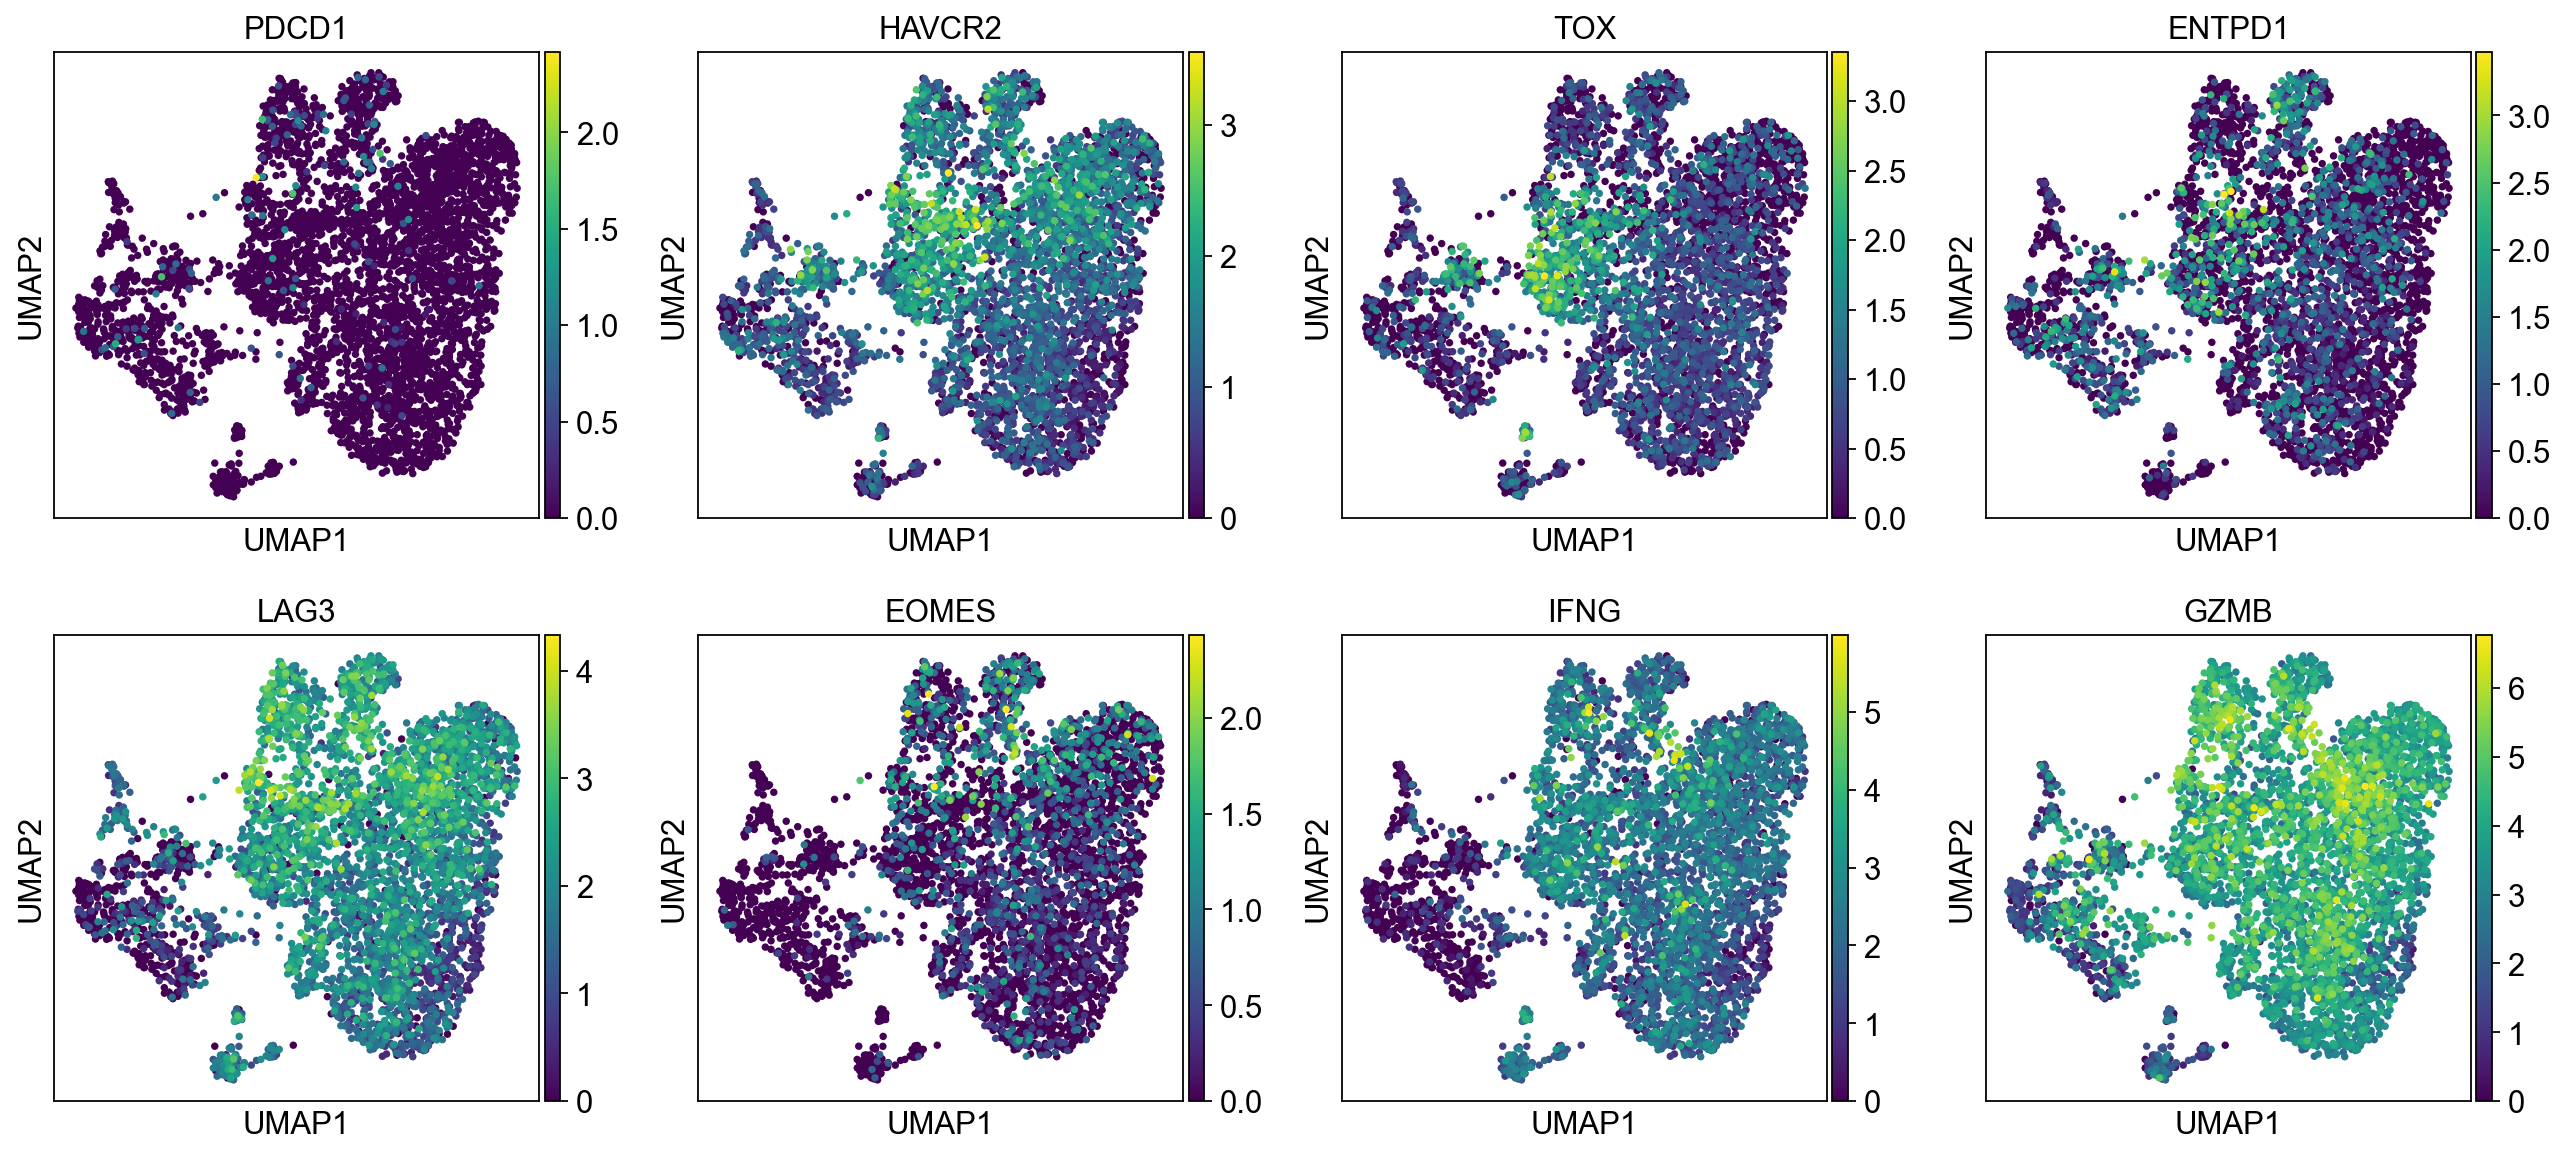

In [54]:
sc.pl.umap(mdata_filtered["gex"], color=["PDCD1", "HAVCR2", "TOX", "ENTPD1", "LAG3", "EOMES", "IFNG", "GZMB"], size=45)

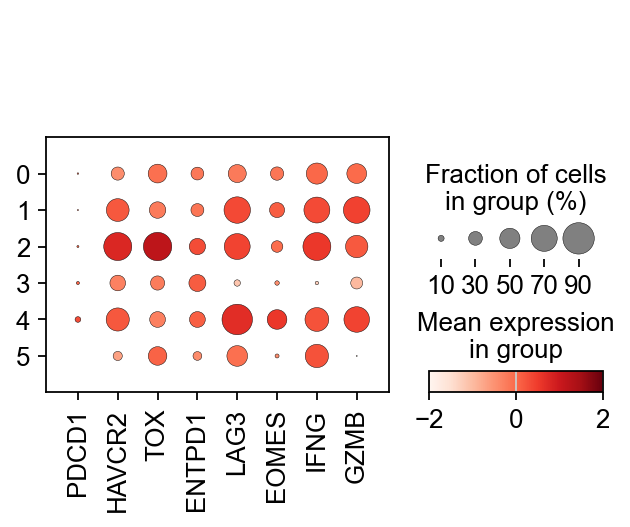

In [47]:
sc.pl.dotplot(mdata_filtered["gex"], 
              ["PDCD1", "HAVCR2", "TOX", "ENTPD1", "LAG3", "EOMES", "IFNG", "GZMB"], 
              groupby="leiden", 
              use_raw=False,
              vmax=2,
              vmin=-2
              )

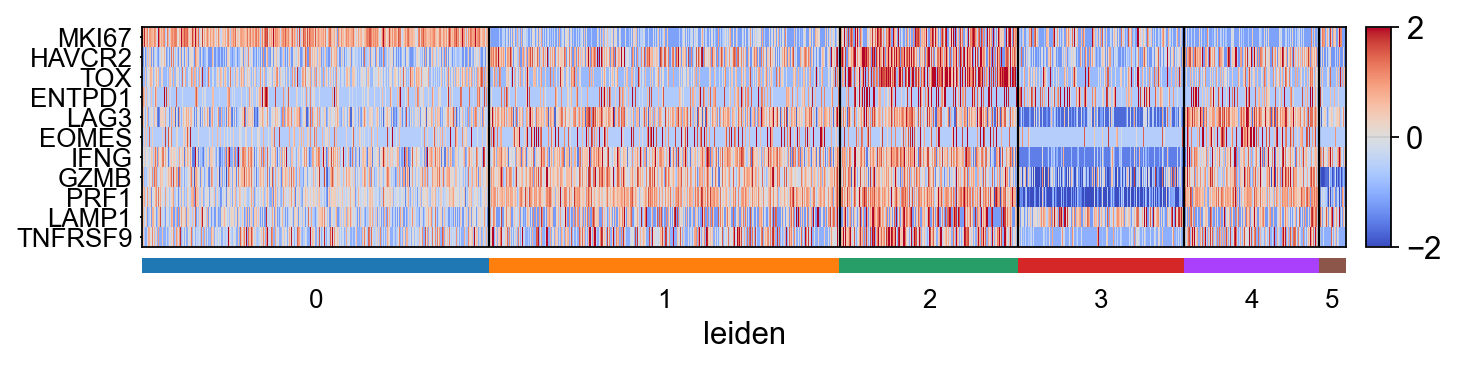

In [55]:
sc.pl.heatmap(mdata_filtered["gex"],
              ["MKI67", "HAVCR2", "TOX", "ENTPD1", "LAG3", "EOMES", "IFNG", "GZMB", "PRF1", "LAMP1", "TNFRSF9"],
              groupby="leiden",
              use_raw=False,
              vmax=2,
              vmin=-2,
              swap_axes=True,
              cmap= "coolwarm"
              )

Cluster 0: T_proliferate
Cluster 1: T_ex/effector(1)
Cluster 2: T_ex/stem-like
Cluster 3: T_bystander(1)
Cluster 4: T_ex/effector(2)
Cluster 5: T_bystander(2)

In [56]:
sc.tl.rank_genes_groups(mdata_filtered["gex"], groupby="leiden", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [60]:
degs = sc.get.rank_genes_groups_df(mdata_filtered["gex"], group=None, pval_cutoff=0.05)

In [62]:
degs.to_csv("/Users/jerryaaaaaa/tcr_degs.csv")

In [63]:
mdata_filtered.write("/Users/jerryaaaaaa/scTCR_filtered.h5mu")

In [69]:
cdr3_info = ir.get.airr(
    mdata_filtered["airr"],
    airr_variable=["cdr3_aa"],
    chain=["VJ_1", "VDJ_1"]
)
clone_info = mdata_filtered["airr"].obs[["clone_id", "clone_id_size"]].copy()
tcr_info = clone_info.join(cdr3_info, how="inner")

In [70]:
tcr_info.reset_index(inplace=True)

In [71]:
tcr_info.to_csv("/Users/jerryaaaaaa/tcr_filtered_info.csv")

In [72]:
tcr_per_clone = (
    tcr_info.groupby("clone_id")["VDJ_1_cdr3_aa"]
    .agg(lambda x: x.value_counts().index[0])
    .reset_index()
)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_5024/912308583.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tcr_info.groupby("clone_id")["VDJ_1_cdr3_aa"]


In [74]:
tcr_per_clone.to_csv("/Users/jerryaaaaaa/tcr_per_clone_filtered.csv")